In [17]:
import pandas as pd
data = pd.read_csv('Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Checking Missing Values

In [18]:
# Check for missing values
print(data.isnull().sum())


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Checking for Duplicates Values

In [19]:
# Check for duplicate rows
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [20]:
# Convert TotalCharges to numeric, coerce errors to NaN, and fill or drop them
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Convert 'Churn' to binary (1 = Yes, 0 = No)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


In [21]:
# Convert 'gender' using Label Encoding
data['gender'] = data['gender'].map({'Female': 0, 'Male': 1})

# One-Hot Encoding for 'Contract', 'PaymentMethod', etc.
data = pd.get_dummies(data, columns=['Contract', 'PaymentMethod'], drop_first=True)


In [22]:
# Check the distribution of the target variable 'Churn'
churn_distribution = data['Churn'].value_counts()
print(churn_distribution)


Churn
0    5174
1    1869
Name: count, dtype: int64


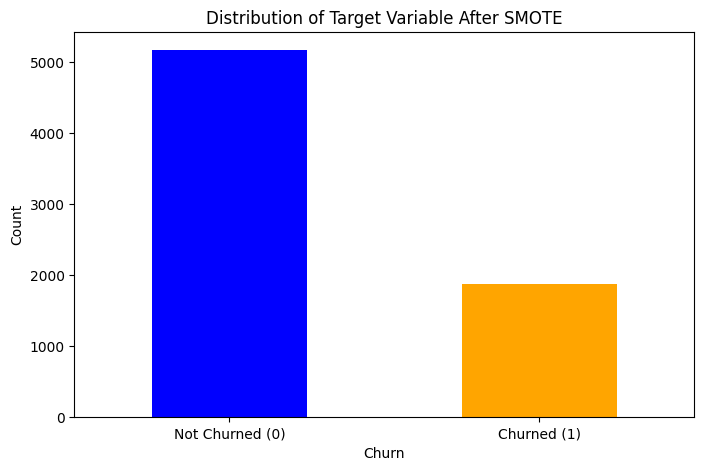

In [23]:
# Plotting the new distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
churn_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Target Variable After SMOTE')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Churned (0)', 'Churned (1)'], rotation=0)
plt.show()

Dataset is imbalanced

In [24]:
# Drop the 'customerID' if not done already since it's not useful for modeling
data = data.drop('customerID', axis=1)

# Encode categorical features if necessary
data_encoded = pd.get_dummies(data, drop_first=True)

# Separate features (X) and target (y)
X = data_encoded.drop('Churn', axis=1)
y = data_encoded['Churn']

In [25]:
# Imputation (replace NaN with mean for numerical features)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median' or 'most_frequent'
X = imputer.fit_transform(X)

# Now apply SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Check the new distribution
new_distribution = pd.Series(y).value_counts()
print(new_distribution)

Churn
0    5174
1    5174
Name: count, dtype: int64


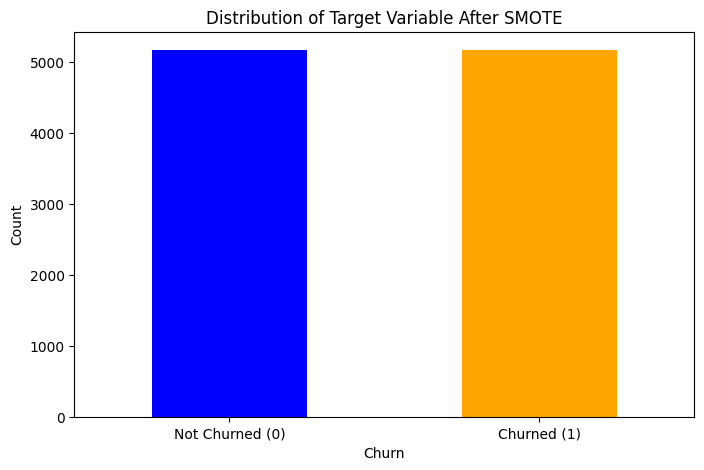

In [26]:
# Plotting the new distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
new_distribution.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Target Variable After SMOTE')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Churned (0)', 'Churned (1)'], rotation=0)
plt.show()

Splitting dataset into 70% train and 30% test

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Random Forest

In [28]:

# Initialize the Random Forest classifier with balanced class weights
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Fit the model on your training data
rf_classifier.fit(X_train, y_train)

# Predict using the trained model
y_pred_rf = rf_classifier.predict(X_test)

# Print the classification report to see performance metrics
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1553
           1       0.87      0.83      0.85      1552

    accuracy                           0.86      3105
   macro avg       0.86      0.86      0.86      3105
weighted avg       0.86      0.86      0.86      3105



Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression with balanced class weights
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit the model
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Performance Metrics
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1553
           1       0.76      0.83      0.79      1552

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Xtreme Gradient

In [30]:
import xgboost as xgb

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(scale_pos_weight=len(y[y == 0]) / len(y[y == 1]), random_state=42)

# Fit the model
xgb_classifier.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_classifier.predict(X_test)

# Print performance metrics
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1553
           1       0.86      0.83      0.85      1552

    accuracy                           0.85      3105
   macro avg       0.85      0.85      0.85      3105
weighted avg       0.85      0.85      0.85      3105



LightGBM (Light Gradient Boosting Machine)

In [31]:
import lightgbm as lgb

# Initialize the LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(scale_pos_weight=len(y[y == 0]) / len(y[y == 1]), random_state=42)

# Fit the model
lgb_classifier.fit(X_train, y_train)

# Predictions
y_pred_lgb = lgb_classifier.predict(X_test)

# Print performance metrics
print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 3622, number of negative: 3621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5202
[LightGBM] [Info] Number of data points in the train set: 7243, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500069 -> initscore=0.000276
[LightGBM] [Info] Start training from score 0.000276
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1553
           1       0.87      0.84      0.85      1552

    accuracy                           0.86      3105
   macro avg       0.86      0.86      0.86      3105
weighted avg       0.86      0.86      0.86      3105



Evaluating Model Performance

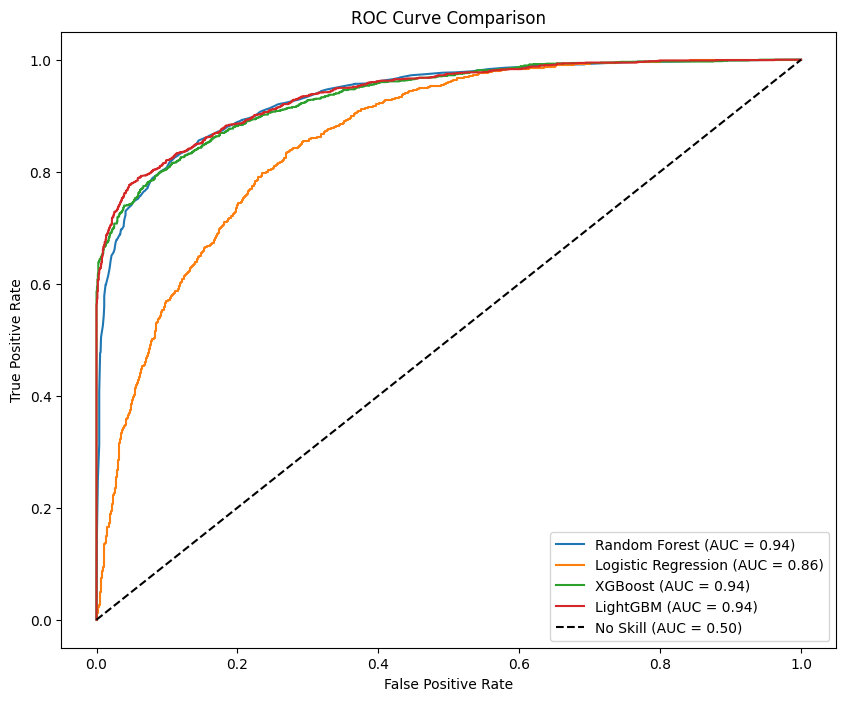

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute probabilities and ROC AUC for Random Forest
y_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Compute probabilities and ROC AUC for Logistic Regression
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

# Compute probabilities and ROC AUC for XGBoost
y_prob_xgb = xgb_classifier.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Compute probabilities and ROC AUC for LightGBM
y_prob_lgb = lgb_classifier.predict_proba(X_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)
auc_lgb = roc_auc_score(y_test, y_prob_lgb)

# Plotting all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


Hyperparameter Tuning

In [33]:
from sklearn.model_selection import GridSearchCV

# Set up parameter grids for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.1]
}

param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.1]
}

# Create grid search objects
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1)
grid_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, scoring='roc_auc', n_jobs=-1)
grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1)
grid_lgb = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid_lgb, cv=3, scoring='roc_auc', n_jobs=-1)

# Fit grids
grid_rf.fit(X_train, y_train)
grid_lr.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_lgb.fit(X_train, y_train)

# Display best parameters for each model
print("Best parameters (RF):", grid_rf.best_params_)
print("Best parameters (LR):", grid_lr.best_params_)
print("Best parameters (XGB):", grid_xgb.best_params_)
print("Best parameters (LGB):", grid_lgb.best_params_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

[LightGBM] [Info] Number of positive: 2415, number of negative: 2414
[LightGBM] [Info] Number of positive: 2415, number of negative: 2414
[LightGBM] [Info] Number of positive: 2414, number of negative: 2414
[LightGBM] [Info] Number of positive: 2415, number of negative: 2414
[LightGBM] [Info] Number of positive: 2414, number of negative: 2414
[LightGBM] [Info] Number of positive: 2415, number of negative: 2414
[LightGBM] [Info] Number of positive: 2414, number of negative: 2414
[LightGBM] [Info] Number of positive: 2415, number of negative: 2414
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4878
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

 Model Evaluation and Validation


In [34]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate each model
models = {
    'Random Forest': grid_rf.best_estimator_,
    'Logistic Regression': grid_lr.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'LightGBM': grid_lgb.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} ROC AUC:", roc_auc_score(y_test, y_prob))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1553
           1       0.87      0.85      0.86      1552

    accuracy                           0.86      3105
   macro avg       0.86      0.86      0.86      3105
weighted avg       0.86      0.86      0.86      3105

Random Forest ROC AUC: 0.9405212558334052
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1553
           1       0.75      0.83      0.79      1552

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105

Logistic Regression ROC AUC: 0.860282061324606
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1553
           1       0.86      0.84    

K-Fold Cross Validation

In [35]:
from sklearn.model_selection import cross_val_score

# Example settings
k = 5  # Number of folds
scoring_method = 'roc_auc'  # Evaluation metric

models = {
    'Random Forest': grid_rf.best_estimator_,
    'Logistic Regression': grid_lr.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'LightGBM': grid_lgb.best_estimator_
}

# Performing cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring=scoring_method)
    print(f"{name} {scoring_method} Scores: {scores}")
    print(f"Average {scoring_method} for {name}: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")


Random Forest roc_auc Scores: [0.94551724 0.92994094 0.94424843 0.93484822 0.9338972 ]
Average roc_auc for Random Forest: 0.938 (+/- 0.012)
Logistic Regression roc_auc Scores: [0.86431701 0.85433797 0.85905315 0.84774961 0.83504491]
Average roc_auc for Logistic Regression: 0.852 (+/- 0.020)
XGBoost roc_auc Scores: [0.94465612 0.93767098 0.9451867  0.93597475 0.93860268]
Average roc_auc for XGBoost: 0.940 (+/- 0.008)
[LightGBM] [Info] Number of positive: 2898, number of negative: 2896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4972
[LightGBM] [Info] Number of data points in the train set: 5794, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500173 -> initscore=0.000690
[LightGBM] [Info] Start training from score 0.000690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Info] Number of positive: 2898, number of negative: 2896
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4972
[LightGBM] [Info] Number of data points in the train set: 5794, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500173 -> initscore=0.000690
[LightGBM] [Info] Start training from score 0.000690
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

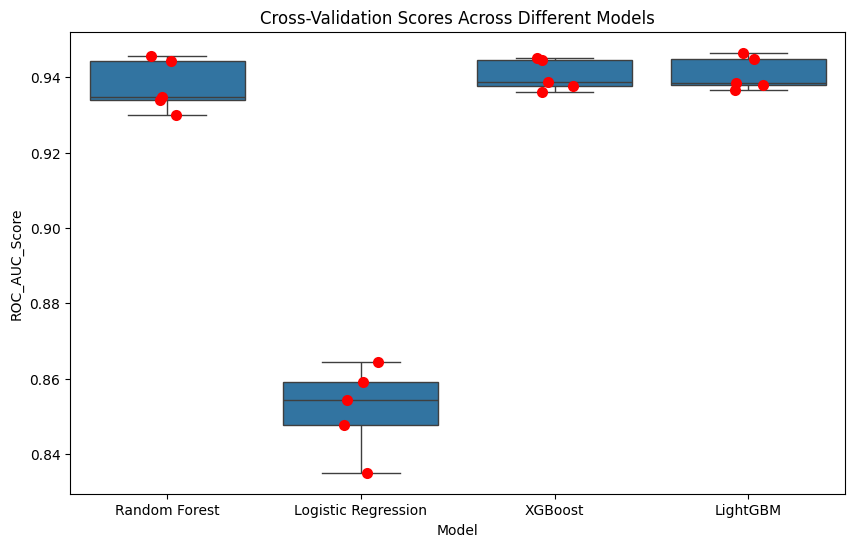

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect all model scores in a list for plotting
cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring=scoring_method)
    for score in scores:
        cv_results.append({'Model': name, 'ROC_AUC_Score': score})

# Convert list to DataFrame
df_cv_results = pd.DataFrame(cv_results)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='ROC_AUC_Score', data=df_cv_results)
sns.stripplot(x='Model', y='ROC_AUC_Score', data=df_cv_results, color='red', size=8, jitter=True)
plt.title('Cross-Validation Scores Across Different Models')
plt.show()


In [37]:
import pickle
import os

models = {
    'Random Forest': grid_rf.best_estimator_,
    'Logistic Regression': grid_lr.best_estimator_,
    'XGBoost': grid_xgb.best_estimator_,
    'LightGBM': grid_lgb.best_estimator_
}

# Set the directory path for model storage
model_path = './Model Backups/'  # './' refers to the current directory
os.makedirs(model_path, exist_ok=True)  # Creates the directory if it does not exist

# Serialize each model using pickle
for name, model in models.items():
    file_path = os.path.join(model_path, f"{name.replace(' ', '_')}_model.pkl")
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)
    print(f'Saved {name} model to {file_path}')


Saved Random Forest model to ./Model Backups/Random_Forest_model.pkl
Saved Logistic Regression model to ./Model Backups/Logistic_Regression_model.pkl
Saved XGBoost model to ./Model Backups/XGBoost_model.pkl
Saved LightGBM model to ./Model Backups/LightGBM_model.pkl
